In [114]:
import pandas as pd
import numpy as np

import re

import importlib
import clean_data


importlib.reload(clean_data)
from clean_data import clean_mktcap, clean_price

## 資料匯入

In [2]:
p = pd.read_excel("因子資料全.xlsx",sheet_name="收盤價")

In [3]:
mk = pd.read_excel("因子資料全.xlsx",sheet_name="市值")


In [ ]:
pe = pd.read_excel("因子資料全.xlsx",sheet_name="低本益比")

In [5]:
pb = pd.read_excel("因子資料全.xlsx",sheet_name="低PB")

In [6]:
y = pd.read_excel("因子資料全.xlsx",sheet_name="殖利率")

In [7]:
b = pd.read_excel("因子資料全.xlsx",sheet_name="Beta")

In [8]:
earning = pd.read_excel("因子資料全.xlsx",sheet_name="月營收")

In [9]:
gross_margin = pd.read_excel("因子資料全.xlsx",sheet_name="毛利率")

In [10]:
rev_margin = pd.read_excel("因子資料全.xlsx",sheet_name="營利率")

In [ ]:
finance_corp = pd.read_excel("因子資料全.xlsx",sheet_name="金融保險（含下市櫃）")

## 資料清洗

In [ ]:
price = clean_price(p)
mktcap = clean_mktcap(mk)
pe_ratio = clean_mktcap(pe)
pb_ratio = clean_mktcap(pb)
yd = clean_mktcap(y)
beta = clean_mktcap(b)
earn_yoy = clean_mktcap(earning)
gross = clean_mktcap(gross_margin)
rev = clean_mktcap(rev_margin)
returns = price.pct_change() #returns矩陣

c:\Users\USER\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.

C:\Users\USER\AppData\Local\Temp\ipykernel_20704\254891627.py:12: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



## 產出Alpha

In [ ]:
import importlib
import alpha
import pe
import yeild
import revenue_growth

importlib.reload(alpha)
importlib.reload(pe)
importlib.reload(yeild)
importlib.reload(revenue_growth)

from alpha import build_sample_pool, build_sample_pool_ex_fin,momentum_signal , pool_to_alpha 
from pe import pe_low_signal
from yeild import dy_high_signal,yoy_high_signal
from revenue_growth import margin_growth_signal #,to_quarter_last, months_for_quarter



In [85]:
top200 = build_sample_pool(mktcap)
top200_nofin = build_sample_pool_ex_fin(mktcap,finance_corp)
top200_alpha = pool_to_alpha(returns, top200)

In [107]:
momentum_01_alpha = momentum_signal(returns, top200,lookback_months=1)
momentum_03_alpha = momentum_signal(returns, top200,lookback_months=3)
momentum_06_alpha = momentum_signal(returns, top200,lookback_months=6)

pe_low_01_alpha = pe_low_signal(returns, pe_ratio, top200_nofin)

pb_low_01_alpha = pe_low_signal(returns, pb_ratio, top200_nofin)

high_yield_alpha = dy_high_signal(returns, yd, top200,require_positive=False)

low_vol_alpha =  pe_low_signal(returns, beta, top200, require_positive=True)

high_yoy_alpha = yoy_high_signal(returns, earn_yoy,top200,yoy_cap_ratio=200,      # 200%
    yoy_is_percent=True,    # 你的數據是百分比
    require_positive=False  # 依你的條件，不強制 >0
)

In [108]:
sig_margin = margin_growth_signal(
    returns=returns, 
    gross=gross, 
    operating=rev, 
    mktcap_pool=top200_nofin
)

In [109]:
def alp_return(alpha: pd.DataFrame, returns: pd.DataFrame) -> pd.Series:
    """
    給定 alpha (0/1 矩陣) 和 returns，計算每日投組報酬。
    """
    weighted_ret = (alpha * returns).sum(axis=1)
    counts = alpha.sum(axis=1)
    return (weighted_ret / counts).dropna()

######

# 2003-2025績效表現分析

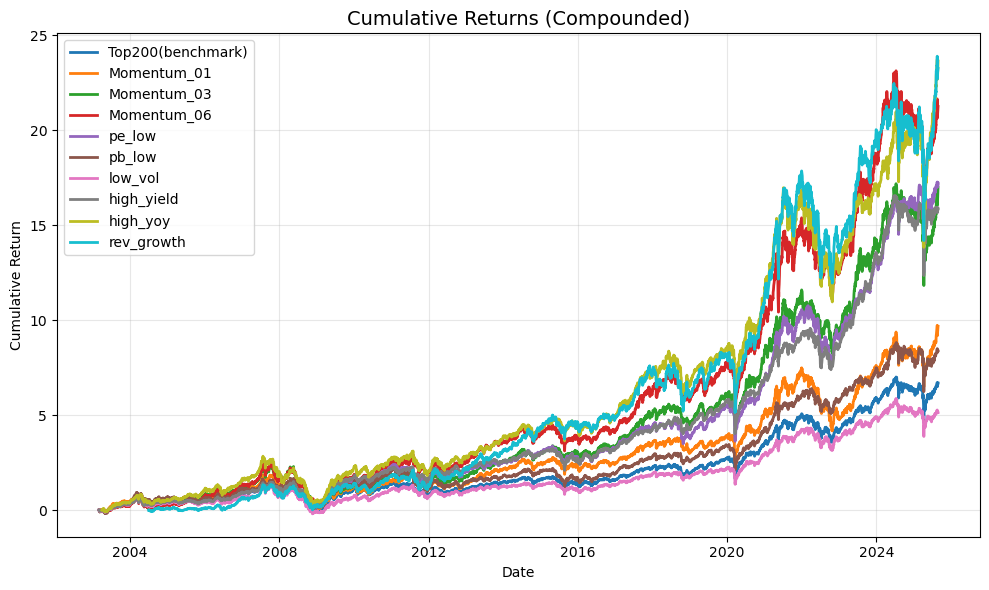

In [110]:
import matplotlib.pyplot as plt

def plot_cum_returns(*series, labels=None, title="Cumulative Returns (Compounded)"):
    """
    輸入一個或多個 return series，畫複利累積報酬
    series: 每個是 pd.Series (index=日期, values=日報酬)
    labels: 對應的名稱
    
    """
    plt.figure(figsize=(10, 6))
    
    for i, s in enumerate(series):
        cum = (1 + s).cumprod() - 1
        label = labels[i] if labels else f"Series {i+1}"
        plt.plot(cum.index, cum.values, label=label, linewidth=2)
    
    plt.title(title, fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

ret_top200 = alp_return(top200_alpha, returns)
ret_mom = alp_return(momentum_01_alpha, returns)
ret_mom3 = alp_return(momentum_03_alpha, returns)
ret_mom6 = alp_return(momentum_06_alpha, returns)
ret_pe_low1 = alp_return(pe_low_01_alpha, returns)
ret_pb_low1 = alp_return(pb_low_01_alpha, returns)
ret_low_vol = alp_return(low_vol_alpha, returns)
ret_high_yield = alp_return(high_yield_alpha,returns)
ret_high_yoy = alp_return(high_yoy_alpha,returns) #lag兩個月
ret_rev_growth = alp_return(sig_margin,returns)
plot_cum_returns(ret_top200, ret_mom,ret_mom3,ret_mom6,ret_pe_low1,ret_pb_low1,ret_low_vol,ret_high_yield,ret_high_yoy,ret_rev_growth,labels=["Top200(benchmark)", "Momentum_01","Momentum_03","Momentum_06","pe_low","pb_low","low_vol","high_yield","high_yoy","rev_growth"])


In [171]:
import pandas as pd
import numpy as np

def perf_summary(returns_dict: dict, freq: int = 252, rf: float = 0.0) -> pd.DataFrame:
    """
    統整策略績效：年化報酬、年化波動率、Sharpe ratio
    
    returns_dict: dict[str, pd.Series] {策略名稱: 日報酬序列}
    freq: 一年交易日數 (預設 252)
    rf: 無風險利率 (日化)，預設 0
    
    回傳：pd.DataFrame
    """
    rows = []
    for name, r in returns_dict.items():
        r = r.dropna()
        ann_ret = (1 + r).prod() ** (freq / len(r)) - 1
        ann_vol = r.std() * np.sqrt(freq)
        sharpe = (ann_ret - rf) / ann_vol if ann_vol > 0 else np.nan
        rows.append([ann_ret, ann_vol, sharpe])
    
    return pd.DataFrame(rows, index=returns_dict.keys(),
                        columns=["Annual Return", "Annual Volatility", "Sharpe Ratio"])

# ---------------- 使用範例 ----------------
perf_table = perf_summary({
    "Momentum_01": ret_mom,
    "Momentum_03": ret_mom3,
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "benchmark":ret_top200
})

perf_table.sort_values(by="Annual Return")


,Annual Return,Annual Volatility,Sharpe Ratio
Low_vol,0.086091,0.187065,0.460218
benchmark,0.097266,0.193963,0.501466
PB_low,0.107213,0.201381,0.532387
Momentum_01,0.113701,0.209270,0.543324
High_yield,0.137034,0.175806,0.779461
Momentum_03,0.140408,0.213475,0.657726
PE_low,0.140849,0.198300,0.710282
Momentum_06,0.151478,0.219799,0.689169
High_yoy,0.157464,0.213661,0.736980
Rev_growth,0.166819,0.223768,0.745499


In [155]:
import interval_report
importlib.reload(interval_report)

from interval_report import perf_report,factor_monthly_heatmap_plotly,factor_rank_tile,factor_rank_tile_full

## 函數1:指定區間因子報酬報表

c:\Users\USER\OneDrive\桌面\清大校務基金\因子投資\interval_report.py:61: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



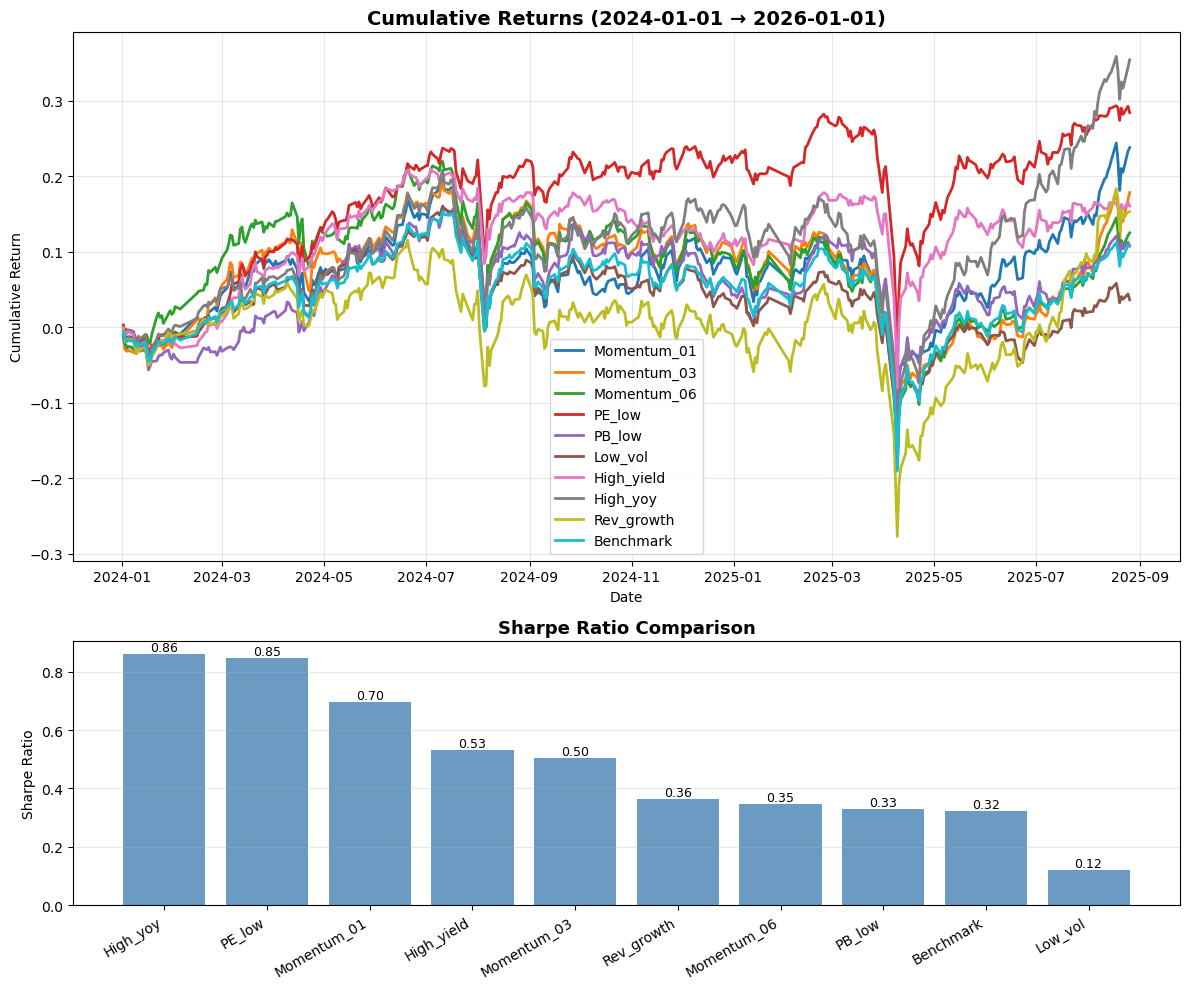

             Annual Return  Annual Volatility  Sharpe Ratio  Total Return
Momentum_01         0.1444             0.2076        0.6956        0.2381
Momentum_03         0.1094             0.2170        0.5043        0.1787
Momentum_06         0.0773             0.2223        0.3478        0.1252
PE_low              0.1714             0.2027        0.8456        0.2846
PB_low              0.0667             0.2026        0.3290        0.1076
Low_vol             0.0228             0.1894        0.1205        0.0364
High_yield          0.0988             0.1858        0.5316        0.1608
High_yoy            0.2113             0.2453        0.8613        0.3546
Rev_growth          0.0942             0.2597        0.3629        0.1533
Benchmark           0.0673             0.2079        0.3235        0.1086


In [141]:
factors = {
    "Momentum_01": ret_mom,
    "Momentum_03": ret_mom3,
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "Benchmark" : ret_top200
}


start= "2024-01-01"
end= "2026-01-01"

# start= "2021-01-01"
# end= "2025-05-01"


report = perf_report(factors, start_date=start, end_date=end)
print(report.round(4))


## 函數2:最近一年因子月表現熱力圖

In [43]:
factors = {
    "Momentum_01": ret_mom,
    "Momentum_03": ret_mom3,
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "Benchmark(top200)":ret_top200
}

heatmap_df = factor_monthly_heatmap_plotly(
    factors,
    end_date="2025-08-26",  # 可省略
    months=12,
    # save_html="factor_heatmap_last12.html"  # 需要就存檔
)


c:\Users\USER\OneDrive\桌面\清大校務基金\因子投資\interval_report.py:115: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\USER\OneDrive\桌面\清大校務基金\因子投資\interval_report.py:126: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [144]:
factor_rank_tile(
    returns_dict={
        "Momentum_01": ret_mom,
        "Momentum_03": ret_mom3,
        "Momentum_06": ret_mom6,
        "PE_Low": ret_pe_low1,
        "PB_Low": ret_pb_low1,
        "LowVol": ret_low_vol,
        "HighYield": ret_high_yield,
        "HighYoY": ret_high_yoy,
        "RevGrowth": ret_rev_growth,
    },
    periods=12,
    freq="M",   # 也可以改 "W" 或 "Y"
    title="Factors Monthly Ranking (Last 12 months)"
)


c:\Users\USER\OneDrive\桌面\清大校務基金\因子投資\interval_report.py:207: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\USER\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



,Period,Factor,Return,Rank,Label
0,2024-09,Momentum_01,-0.028908,5.0,Momentum_01<br>-2.89%
1,2024-10,Momentum_01,-0.025882,5.0,Momentum_01<br>-2.59%
2,2024-11,Momentum_01,0.031783,1.0,Momentum_01<br>3.18%
3,2024-12,Momentum_01,0.009074,3.0,Momentum_01<br>0.91%
4,2025-01,Momentum_01,-0.001041,6.0,Momentum_01<br>-0.10%
...,...,...,...,...,...
103,2025-04,RevGrowth,-0.033998,6.0,RevGrowth<br>-3.40%
104,2025-05,RevGrowth,0.074406,2.0,RevGrowth<br>7.44%
105,2025-06,RevGrowth,0.033688,3.0,RevGrowth<br>3.37%
106,2025-07,RevGrowth,0.117319,1.0,RevGrowth<br>11.73%


In [ ]:
(high_yield_alpha.loc["2020-01-10"].loc[high_yield_alpha.loc["2020-01-10"]==1]).index

Index(['1101', '1102', '1301', '1303', '1314', '1326', '1402', '1434', '1565',
       '1605', '2015', '2027', '2227', '2301', '2324', '2327', '2344', '2347',
       '2356', '2357', '2376', '2377', '2382', '2408', '2409', '2439', '2441',
       '2451', '2456', '2458', '2474', '2492', '2501', '2542', '2548', '2606',
       '2849', '2886', '2890', '2915', '3005', '3036', '3045', '3231', '3532',
       '3702', '3706', '4904', '4938', '5522', '5534', '5820', '6147', '6176',
       '6488', '6505', '8069', '9933', '2404', '8415'],
      dtype='object', name='tickers')

In [ ]:
returns_dict = {
    "Momentum_01": ret_mom,
    "Momentum_03": ret_mom3,
    "PE_Low":      ret_pe_low1,
    "PB_Low":      ret_pb_low1,
    "LowVol":      ret_low_vol,
    "HighYield":   ret_high_yield,
    "HighYoY":     ret_high_yoy,
    "RevGrowth":   ret_rev_growth,
}

_ = factor_rank_tile_full(
    returns_dict=returns_dict,
    periods=12,
    freq="M",                   # "M" / "W" / "Y"
    
    text_size=5,              
    # save_html="factor_rank_last12_months.html",
)


c:\Users\USER\OneDrive\桌面\清大校務基金\因子投資\interval_report.py:312: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\USER\OneDrive\桌面\清大校務基金\因子投資\interval_report.py:337: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



##### 

In [ ]:
# internship、project detail，including github clear

# come up with reasearch plan

# grad school course plan

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ email to prof manager

# motivation 

# conclusion 





In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def stock_perf_report(price_df: pd.DataFrame, start_date: str, end_date: str, tickers: list[str]):
    """
    在指定區間(start_date~end_date)針對多檔股票畫出累積報酬率走勢，
    並計算年化報酬、波動率、Sharpe ratio。
    
    Parameters
    ----------
    price_df : pd.DataFrame
        index = 日期 (DatetimeIndex 或 string 可轉換)，columns = 股票代號 (str)
    start_date : str (e.g. "2020-01-01")
    end_date   : str (e.g. "2024-01-01")
    tickers    : list[str]  股票代號
    
    Returns
    -------
    stats_df : pd.DataFrame
        各股票的績效指標 (年化報酬、波動率、Sharpe)
    """
    # 區間切片
    px = price_df.loc[start_date:end_date, tickers].dropna(how="all")

    # 日報酬率
    ret = px.pct_change().dropna()

    # 累積報酬
    cum_ret = (1 + ret).cumprod() - 1

    # 假設一年252個交易日
    ann_ret = (1 + ret.mean())**252 - 1
    ann_vol = ret.std() * np.sqrt(252)
    sharpe  = ann_ret / ann_vol

    stats_df = pd.DataFrame({
        "Annual Return": ann_ret,
        "Annual Volatility": ann_vol,
        "Sharpe Ratio": sharpe
    })

    # 繪圖
    plt.figure(figsize=(10, 6))
    for t in tickers:
        plt.plot(cum_ret.index, cum_ret[t], label=t, linewidth=2)
    plt.title(f"Stock Performance {start_date} ~ {end_date}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return stats_df


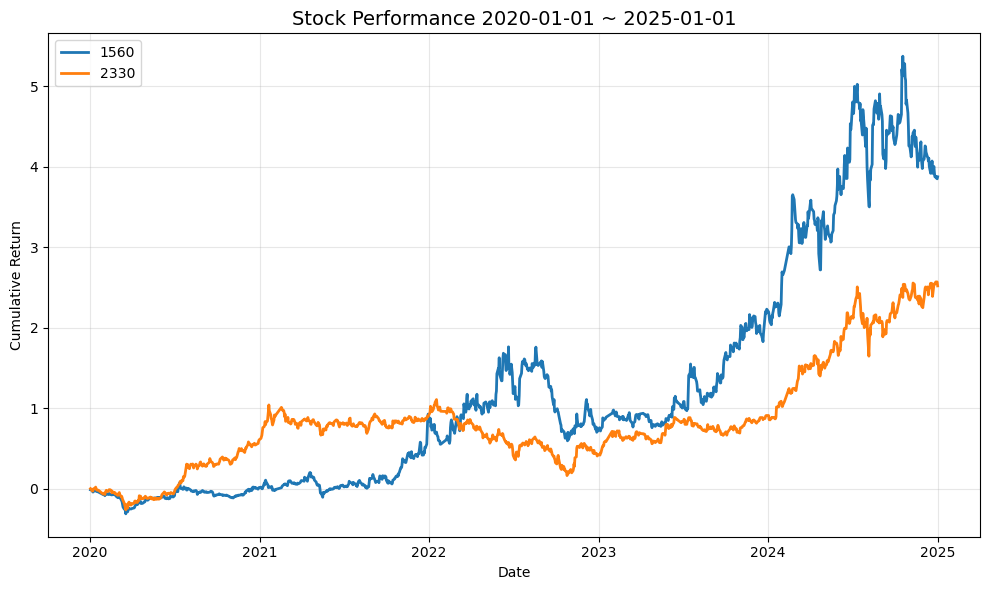

         Annual Return  Annual Volatility  Sharpe Ratio
tickers                                                
1560          0.513767           0.417711      1.229957
2330          0.353959           0.290528      1.218331


In [133]:
# 假設你的價錢 DataFrame 名叫 `p`
stats = stock_perf_report(
    price_df=price,
    start_date="2020-01-01",
    end_date="2025-01-01",
    tickers=["1560" ,"2330"]
)

print(stats)

